In [1]:
import seaborn as sn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import pandas as pd
import numpy as np
import pathlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import datetime
from tensorflow.keras.callbacks import Callback


class Manage_data():
    def __init__(self):
        data_dir='/mnt/data/rag-tt/tactile_images/'
        self.data_dir= pathlib.Path(data_dir)
        
    def find_no_of_images(self, obj_id):
        image_dir = os.path.join(self.data_dir, str(obj_id))
        image_dir= pathlib.Path(image_dir)
        no_of_images= len(list(image_dir.glob('*.jpg')))
        return no_of_images
    
    def balance_data(self, label, image_paths):
        # Ensure label and image_paths are numpy arrays
        label = np.array(label)
        image_paths = np.array(image_paths)
        
        # Count the total number of zeroes in label
        total_zeroes = np.sum(label == 0)
        
        # Determine the number of zeroes to remove
        zeroes_to_remove = max(0, total_zeroes - tune.no_of_nonslip_data)
        
        # Indices of zero elements
        zero_indices = np.where(label == 0)[0]
        
        # Indices to keep (last self.no_of_nonslip_data zeroes and all ones)
        indices_to_keep = np.concatenate((zero_indices[-tune.no_of_nonslip_data:], np.where(label != 0)[0]))
        indices_to_keep = np.unique(indices_to_keep)
        indices_to_keep = np.sort(indices_to_keep)
        
        # Create the resulting label array
        new_label = label[indices_to_keep]
        
        # Remove the same number of elements from the start of image_paths
        new_image_paths = image_paths[zeroes_to_remove:]
        # print('label', label.shape)
        # print('image_paths', image_paths.shape)
        # print('new_label', new_label.shape)
        # print('new_image_paths', new_image_paths.shape)
        return new_label, new_image_paths
    
    def check_pattern(self,label):
        # Ensure arr is a numpy array
        label = np.array(label)
        
        # Find the first occurrence of 1
        first_one_index = np.argmax(label == 1)
        
        if np.all(label == 0):  # If there's no 1 in the array, ensure all are 0
            return
        
        # Check if there's no 1 in the array
        if np.max(label) == 0:
            assert np.all(label == 0), "Array does not follow the pattern: continuous zeroes followed by continuous ones"
            return
        
        # Assert all elements before first_one_index are 0
        assert np.all(label[:first_one_index] == 0), "Array does not follow the pattern: continuous zeroes followed by continuous ones"
        
        # Assert all elements from first_one_index to the end are 1
        assert np.all(label[first_one_index:] == 1), "Array does not follow the pattern: continuous zeroes followed by continuous ones"
    
    def create_slip_instant_labels(self, csv_path):
        label = []
        slip_values = np.genfromtxt(csv_path, delimiter=',', skip_header=1, usecols=2, dtype=None, encoding=None)
        for slip_value in slip_values:
            if slip_value < tune.slip_instant_labels:
                label.append(0)
            else:
                label.append(1)
        return label
            
            
            
        
    def load_data(self, no_of_samples = 600):
        file_paths = []
        image_paths = []
        sequential_image_paths = []
        y = []
        window_size = tune.sequence_of_images
        for obj_id in range(no_of_samples):
            no_of_images = self.find_no_of_images(obj_id)
            csv_path = os.path.join(self.data_dir, str(obj_id),'slip_log.csv')
            if no_of_images < 40 or not os.path.exists(csv_path):
                continue
            
            
            
            label2 = self.create_slip_instant_labels(csv_path)
            label = np.genfromtxt(csv_path, delimiter=',', skip_header=1, usecols=1, dtype=None, encoding=None)
            
            for img_id in range(no_of_images):
                image_path = os.path.join(self.data_dir, str(obj_id), str(img_id)+ '.jpg')
                image_paths.append(image_path)
            self.check_pattern(label)
            
            # label, image_paths = self.balance_data(label,image_paths)    
            y.append(label[:-(tune.sequence_of_images-1)])
            
            for i in range(0, len(image_paths) - (tune.sequence_of_images-1)):  # Ensuring sequences of 5 images
                row = image_paths[i:i+tune.sequence_of_images]
                sequential_image_paths.append(row)
            image_paths = []

        y = np.concatenate(y)
        self.labels = np.array(y)

        self.file_paths = np.array(sequential_image_paths)
        
    def shuffle_file_paths(self):
        # Shuffle the dataset
        indices = np.arange(len(self.file_paths))
        np.random.shuffle(indices)
        self.file_paths = self.file_paths[indices]
        self.labels = self.labels[indices]
        
    def shuffle_train_file_paths(self):
        # Shuffle the dataset
        indices = np.arange(len(self.train_filepaths))
        np.random.shuffle(indices)
        self.train_filepaths = self.train_filepaths[indices]
        self.train_labels = self.train_labels[indices]
        
    def create_split_filepaths(self,train=0.7,val=0.2):
        dataset_size = len(self.file_paths)
        train_size = int(train * dataset_size)

        val_size = int(val * dataset_size)
        
        test_size = dataset_size - train_size - val_size
        print('dataset_size=', dataset_size)
        print('train size=', train_size)
        print('test size=', test_size)
        print('val size=', val_size)
        self.train_filepaths = self.file_paths[ : train_size]
        self.val_filepaths = self.file_paths[train_size : train_size+val_size]
        self.test_filepaths = self.file_paths[train_size+val_size : ]
        
        self.train_labels = self.labels[ : train_size]
        self.val_labels = self.labels[train_size : train_size+val_size]
        self.test_labels = self.labels[train_size+val_size : ]
        
        # Check the sizes of the splits
        assert len(self.train_filepaths) == train_size, "Training set size mismatch"
        assert len(self.val_filepaths) == val_size, "Validation set size mismatch"
        assert len(self.test_filepaths) == test_size, "Test set size mismatch"
        assert len(self.train_labels) == train_size, "Training set size mismatch"
        assert len(self.val_labels) == val_size, "Validation set size mismatch"
        assert len(self.test_labels) == test_size, "Test set size mismatch"
        
    def parse_function_vgg(self, filenames, label):
        images = []
        for filename in filenames:
            image_string = tf.io.read_file(filename)
            image_decoded = tf.image.decode_jpeg(image_string, channels=3)
            image_resized = tf.image.resize(image_decoded, [224, 224])  # Adjust size as needed
            # Convert image to a float32 tensor and preprocess it for VGG16
            image = tf.cast(image_resized, tf.float32)
            image = preprocess_input(image)
            # Ensure images are float32 and normalized between 0 and 1
            images.append(image)
        images = tf.stack(images)
        return images, label
        
    def create_dataset(self,file_paths, labels):
                # Create a TensorFlow dataset from the file paths and labels
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        

        def wrapped_parse_function(filenames, label):
            images, label = tf.py_function(func=self.parse_function_vgg, inp=[filenames, label], Tout=[tf.float32, tf.int64])
            images.set_shape((tune.sequence_of_images, 224, 224, 3))  # Explicitly set the shape
            label.set_shape([])  # Explicitly set the shape for the label
            return images, label
 
        
        dataset = dataset.map(wrapped_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(tune.batch_size)  # Adjust batch size as needed
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset
        
    def create_split_datasets(self):
        self.train_dataset = self.create_dataset(self.train_filepaths, self.train_labels)
        self.val_dataset = self.create_dataset(self.val_filepaths, self.val_labels)
        self.test_dataset = self.create_dataset(self.test_filepaths, self.test_labels)
    
    
    def load_evaluation_data(self,start_id=0, no_of_samples=100):
        file_paths = []
        image_paths = []
        sequential_image_paths = []
        y = []

        for obj_id in range(start_id, no_of_samples+100):
            no_of_images = self.find_no_of_images(obj_id)
            csv_path = os.path.join(self.data_dir, str(obj_id), 'slip_log.csv')
            if no_of_images < 40 or not os.path.exists(csv_path):
                continue

            label = np.genfromtxt(csv_path, delimiter=',', skip_header=1, usecols=1, dtype=None, encoding=None)

            for img_id in range(no_of_images):
                image_path = os.path.join(self.data_dir, str(obj_id), str(img_id) + '.jpg')
                image_paths.append(image_path)
            self.check_pattern(label)

            y.append(label[:-(tune.sequence_of_images - 1)])

            for i in range(0, len(image_paths) - (tune.sequence_of_images - 1)):  # Ensuring sequences of images
                row = image_paths[i:i + tune.sequence_of_images]
                sequential_image_paths.append(row)
            image_paths = []

        y = np.concatenate(y)
        eval_labels = np.array(y)
        eval_file_paths = np.array(sequential_image_paths)
        
        return eval_file_paths, eval_labels

    def create_evaluation_dataset(self,start_id=0, no_of_samples=100):
        eval_file_paths, eval_labels = self.load_evaluation_data(start_id=start_id, no_of_samples=no_of_samples)
        return self.create_dataset(eval_file_paths, eval_labels)
    
class create_network():

    def __init__(self):
        self.x =0
        
    def cnn_lstm1(self):

        # Define CNN model
        cnn_model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(480, 640, 3),kernel_regularizer=l1(tune.regularizaion_const)),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten()  # Flatten the spatial dimensions
        ])

        
        # Define LSTM model
        lstm_model = Sequential([
            LSTM(64,input_shape=(tune.sequence_of_images, 144768),kernel_regularizer=l1(tune.regularizaion_const) ),
            Dense(8, activation='relu', kernel_regularizer=l1(tune.regularizaion_const)),
            Dense(1, activation='sigmoid'),
        ])

        # Combine CNN and LSTM models
        self.model = Sequential([
            TimeDistributed(cnn_model, input_shape=(tune.sequence_of_images, 480, 640, 3)),  # Apply CNN to each frame in the sequence
            (Reshape((tune.sequence_of_images,144768))),
            lstm_model,
        ])
        self.model.summary()

    def vgg_lstm(self):
        # VGG16 model with pre-trained weights
        #include top  false remove the final classification layer
        vgg_model = tf.keras.applications.VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
        # Freeze the VGG16 layers if you don't want to train them
        
        # Retain only the first n layers of the VGG16 model
        vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[tune.vgg_layers-1].output)
      
        for layer in vgg_model.layers:
            layer.trainable = False
            
        additional_conv = Sequential([
            vgg_model,
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2))
        ])

        # Define CNN model
        vgg_model_flatten = Sequential([
            additional_conv,
            # Flatten(),  # Flatten the spatial dimensions
            GlobalAveragePooling2D(),  # Use Global Average Pooling instead of Flatten
            # Dense(tune.dense_neurons1, activation='relu'),
            # Dropout(tune.dropout1)
        ])
        
        vgg_model_flatten.summary()
        #25088 is the output of vff_model_flatten
        # Define LSTM model
        lstm_model = Sequential([
            LSTM(64, input_shape=(tune.sequence_of_images, tune.dense_neurons1)),
            Dropout(tune.dropout2),  # Dropout layer to prevent overfitting
            Dense(tune.dense_neurons2, activation='relu'),
            Dropout(tune.dropout3),
            Dense(1, activation='sigmoid'),
                ])

        # Combine CNN and LSTM models
        self.model = Sequential([
            TimeDistributed(vgg_model_flatten, input_shape=(tune.sequence_of_images, 224, 224, 3)),  # Apply CNN to each frame in the sequence
            (Reshape((tune.sequence_of_images,tune.dense_neurons1))),
            lstm_model,
        ])
        vgg_model.summary()
        
        self.model.summary()
        
    def train(self, train_dataset, val_dataset):
        cp = ModelCheckpoint('model_vgg_test/',monitor='val_accuracy',save_best_only=True)
            # EarlyStopping callback to stop training when validation accuracy stops improving
        es = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        #tensor board
        tb= tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                # Shuffle training dataset before each epoch
        # train_dataset_shuffled = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), reshuffle_each_iteration=tune.reshuffle)
        self.model.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=tune.learning_rate),metrics=['accuracy'])
        self.model.fit(train_dataset,validation_data=val_dataset, epochs=tune.epochs, callbacks=[cp,es,accuracy_history])
        
class AccuracyHistory(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_count = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.sequence_of_image = []
        self.learning_rate = []
        self.reshuffle =  []
        self.dropout1 = []
        self.dropout2 = []
        self.dropout3 = []
        self.dropout4 = []
        self.regularization_constant = []
        self.batch_size = []
        self.dense_neurons1 =[]
        self.dense_neurons2 =[]
        self.no_of_samples = []
        self.epochs  = []
        self.vgg_layers = []
        self.other_param = []
        self.no_of_nonslip_data = []   
        self.slip_instant_labels = []
             
    def reset_dict(self):
        self.epoch_count = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.sequence_of_image = []
        self.learning_rate = []
        self.reshuffle =  []
        self.dropout1 = []
        self.dropout2 = []
        self.dropout3 = []
        self.dropout4 = []
        self.regularization_constant = []
        self.batch_size = []
        self.dense_neurons1 =[]
        self.dense_neurons2 =[]
        self.no_of_samples = []
        self.epochs  = []
        self.vgg_layers = []
        self.other_param = []
        self.no_of_nonslip_data = []
        self.slip_instant_labels = [] 
        
    def on_epoch_end(self, epoch, logs={'accuracy':0,'val_accuracy':0}):
        self.epoch_count.append(epoch + 1)
        self.train_accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.sequence_of_image.append(tune.sequence_of_images)
        self.learning_rate.append(tune.learning_rate)
        self.reshuffle.append(tune.reshuffle)
        self.dropout1.append(tune.dropout1)
        self.dropout2.append(tune.dropout2)
        self.dropout3.append(tune.dropout3)
        self.dropout4.append(tune.dropout4)
        self.regularization_constant.append(tune.regularization_constant)
        self.batch_size.append(tune.batch_size)
        self.dense_neurons1.append(tune.dense_neurons1)
        self.dense_neurons2.append(tune.dense_neurons2)
        self.no_of_samples.append(tune.no_of_samples)
        self.epochs.append(tune.epochs )
        self.vgg_layers.append(tune.vgg_layers)
        self.other_param.append(tune.other_param)
        self.no_of_nonslip_data.append(tune.no_of_nonslip_data)
        self.slip_instant_labels.append(tune.slip_instant_labels)
        
    def create_accuracy_dataframe(self):
        accuracy_df = pd.DataFrame({
            'Epoch': self.epoch_count,
            'Train_Accuracy': self.train_accuracy,
            'Val_Accuracy': self.val_accuracy,
            'Sequence_of_Image': self.sequence_of_image,
            'Learning_Rate': self.learning_rate,
            'Reshuffle': self.reshuffle,
            'Dropout1': self.dropout1,
            'Dropout2': self.dropout2,
            'Dropout3': self.dropout3,
            'Dropout4': self.dropout4,
            'Regularization_Constant': self.regularization_constant,
            'Batch_Size': self.batch_size,
            'dense_neurons1': self.dense_neurons1,
            'dense_neurons2': self.dense_neurons2,
            'no_of_samples':self.no_of_samples,
            'epochs':self.epochs, 
            'vgg_layers':self.vgg_layers,
            'other_param':self.other_param,
            'no_of_nonslip_data':self.no_of_nonslip_data,
            'slip_instant_labels':self.slip_instant_labels
        })
        return accuracy_df    
    def save_to_csv(self, accuracy_df):
            # Start with summary1.csv
            file_number = 0
            while True:
                filename = 'tune_log/'+'summary' + str(file_number) + '.csv'
                # Check if the file already exists
                if not os.path.isfile(filename):
                    break
                file_number += 1
            filename_model ='tune_log/'+ 'model' + str(file_number) + '.h5'
            network.model.save(filename_model)
            accuracy_df.to_csv(filename, index=False)    
        
class tuning():
    def __init__(self):
        self.sequence_of_image_array = [6,8,9,10]
        self.learning_rate_array = [0.00005,0.00003, 0.00004, 0.00001,0.0000008, 0.000006 ]
        self.reshuffle_array=[False, True]
        self.regularization_constant_array = [0.01, 0.05, 0.1, 0.2, 0.3]
        self.dense_neurons2_array = [8, 16, 32]
        self.vgg_layers_array= [7,11,15,19]
        self.sequence_of_images =  self.sequence_of_image_array[0]
        self.learning_rate = self.learning_rate_array[1]
        self.reshuffle =  self.reshuffle_array[0]
        self.dropout1 = 0.5
        self.dropout2 = 0.5
        self.dropout3 = 0.5
        self.dropout4 = 0.5
        self.regularization_constant = 0.001
        self.batch_size = 4
        self.dense_neurons1 = 64
        self.dense_neurons2 = 8
        self.csv_id = 0
        self.no_of_samples = 100
        self.epochs = 50
        self.vgg_layers = 19
        self.other_param='additional cnn + global average'
        self.no_of_nonslip_data = 8
        self.slip_instant_labels = 0.001
        
    def start_training(self):
        try:
            manage_data.load_data(no_of_samples=self.no_of_samples)
            # manage_data.shuffle_file_paths()
            manage_data.create_split_filepaths()
            manage_data.shuffle_train_file_paths()
            manage_data.create_split_datasets()
            network.vgg_lstm()
            
            #print the tuning parametrs before training
            accuracy_history.on_epoch_end(0)
            df = accuracy_history.create_accuracy_dataframe()
            # Transpose the DataFrame
            df_transposed = df.transpose()
            print(df_transposed)
            network.train(manage_data.train_dataset, manage_data.val_dataset)
        
        # Ensure accuracy data is saved even if training is interrupted 
        finally:        
            # Create a DataFrame from the accuracy history lists
            accuracy_df = accuracy_history.create_accuracy_dataframe()

            # Save the DataFrame to a CSV file
            accuracy_history.save_to_csv(accuracy_df)
            accuracy_history.reset_dict()                    
    def Tune(self):
   
        for value in self.sequence_of_image_array:
            self.sequence_of_images = value           
            self.start_training()
        self.sequence_of_images = 5
        

def list_subdirectories(directory):
    try:
        # Get the list of all entries in the directory
        entries = os.listdir(directory)
        
        # Filter out and list only the directories
        subdirs = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
        
        return subdirs
    except FileNotFoundError:
        return f"The directory '{directory}' does not exist."
    except PermissionError:
        return f"Permission denied to access '{directory}'."
    

manage_data = Manage_data()
network = create_network()
manage_data= Manage_data()
tune = tuning()
accuracy_history = AccuracyHistory()

from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model = load_model('./tune_log/model20.h5')
# Print the model summary to confirm it was loaded correctly
model.summary()

# Create evaluation dataset
evaluation_dataset = manage_data.create_evaluation_dataset(start_id=0, no_of_samples=100)

# Predict labels for the evaluation dataset
y_predicted = model.predict(evaluation_dataset)



# manage_data.load_data(no_of_samples=500)
# # manage_data.shuffle_file_paths()
# manage_data.create_split_filepaths()
# manage_data.shuffle_train_file_paths()
# manage_data.create_split_datasets()
# for X in manage_data.train_dataset:
    
#     for X1 in X:
#         print('X= ',X1.shape)

2024-06-09 17:34:40.216022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 17:34:41.210884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-09 17:34:42.375506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1308 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:5e:00.0, compute capability: 8.6
2024-06-09 17:34:42.376237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10537 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2024-06-09 17:34:42.376851: I tens

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 6, 64)             15009664  
 ributed)                                                        
                                                                 
 reshape (Reshape)           (None, 6, 64)             0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 33553     
                                                                 
Total params: 15043217 (57.39 MB)
Trainable params: 328529 (1.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


2024-06-09 17:34:45.423733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-06-09 17:34:45.594972: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-09 17:34:45.910581: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 310.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-09 17:34:45.910655: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 604.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-09 17:34:45.914172: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allo

   6/5495 [..............................] - ETA: 3:20 

2024-06-09 17:34:46.316221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5495/5495 [==============================] - 615s 112ms/step


In [3]:
y_predicted = np.array(y_predicted)
# Print without truncation
np.set_printoptions(threshold=np.inf)
print(y_predicted)


[[2.82734400e-05]
 [2.78084226e-05]
 [2.77535291e-05]
 [2.80120657e-05]
 [2.79372071e-05]
 [2.78891621e-05]
 [2.80989643e-05]
 [2.78758907e-05]
 [2.83055178e-05]
 [2.79461347e-05]
 [2.76893170e-05]
 [2.78114458e-05]
 [2.77731997e-05]
 [2.77779163e-05]
 [2.75834191e-05]
 [2.76564861e-05]
 [2.75087077e-05]
 [2.75316488e-05]
 [2.77734925e-05]
 [2.75711645e-05]
 [2.76418778e-05]
 [2.76487317e-05]
 [2.79583146e-05]
 [2.79956148e-05]
 [2.79093019e-05]
 [2.79461055e-05]
 [2.79936939e-05]
 [2.80051736e-05]
 [2.80966087e-05]
 [2.80850345e-05]
 [2.81892808e-05]
 [2.79002525e-05]
 [2.82311667e-05]
 [2.79423239e-05]
 [2.79012111e-05]
 [2.77457748e-05]
 [2.77836116e-05]
 [2.81494686e-05]
 [2.81053963e-05]
 [2.80827844e-05]
 [2.78423358e-05]
 [2.79965243e-05]
 [2.81519642e-05]
 [2.79410433e-05]
 [2.74483064e-05]
 [2.74811773e-05]
 [2.69394313e-05]
 [2.69129596e-05]
 [2.69455468e-05]
 [2.70634155e-05]
 [2.70346045e-05]
 [2.65780454e-05]
 [2.68861750e-05]
 [7.50483450e-05]
 [3.05962130e-05]
 [2.919403

In [4]:
y_pred =[]
for element in y_predicted:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [5]:
# Convert the labels array to a DataFrame
df = pd.DataFrame(y_predicted, columns=['y_predicted'])

# Save the DataFrame to a CSV file
df.to_csv('tune_log/summary20_pred.csv', index=False)

In [6]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [7]:
# Extract labels from the evaluation dataset
def extract_labels_from_dataset(dataset):
    labels = []
    for _, label_batch in dataset:
        labels.extend(label_batch.numpy())
    return np.array(labels)


In [8]:
# Extracting labels
evaluation_labels = extract_labels_from_dataset(evaluation_dataset)

In [9]:
evaluation_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

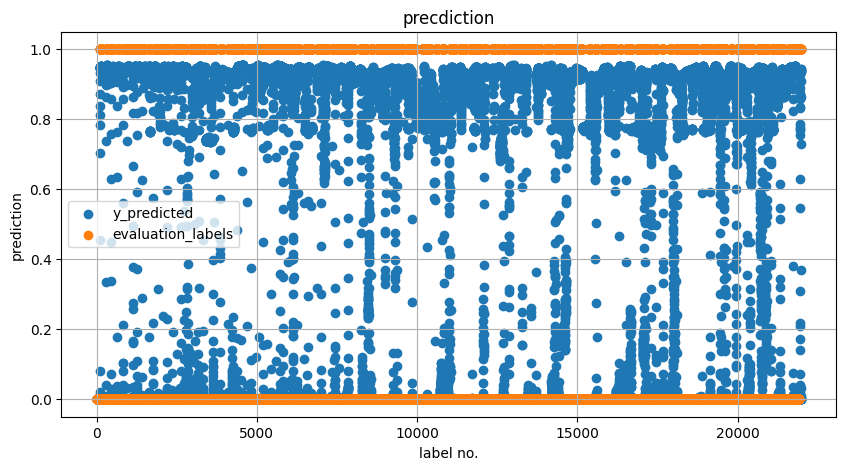

In [10]:

import matplotlib.pyplot as plt

x=[]
for i in range(y_predicted.size):
    x.append(i)
# Plot the data
plt.figure(figsize=(10, 5))
plt.scatter(x, y_predicted, label='y_predicted')
plt.scatter(x, evaluation_labels, label='evaluation_labels')
plt.xlabel('label no.')
plt.ylabel('prediction')
plt.title('precdiction')
plt.legend()
plt.grid(True)
plt.show()

Text(95.72222222222221, 0.5, 'Truth')

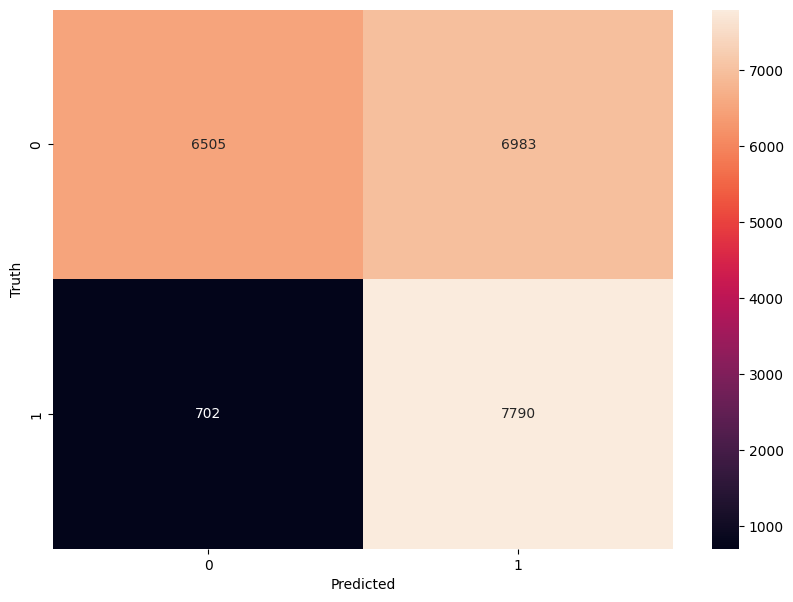

In [11]:
import seaborn as sn

cm = tf.math.confusion_matrix(labels=evaluation_labels, predictions=y_pred)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [12]:

# Create evaluation dataset
evaluation_dataset2 = manage_data.create_evaluation_dataset(start_id=100, no_of_samples=100)

# Predict labels for the evaluation dataset
y_predicted2 = model.predict(evaluation_dataset2)

   4/2695 [..............................] - ETA: 3:25

2695/2695 [==============================] - 299s 111ms/step


2024-06-09 17:57:58.254278: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 900.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [13]:

        
# Convert the labels array to a DataFrame
df = pd.DataFrame(y_predicted2, columns=['y_predicted2'])

# Save the DataFrame to a CSV file
df.to_csv('tune_log/summary20_pred.csv', index=False)

# Extracting labels
evaluation_labels2 = extract_labels_from_dataset(evaluation_dataset2)

In [14]:
y_pred2 =[]
for element in y_predicted2:
    if element > 0.5:
        y_pred2.append(1)
    else:
        y_pred2.append(0)

Text(95.72222222222221, 0.5, 'Truth')

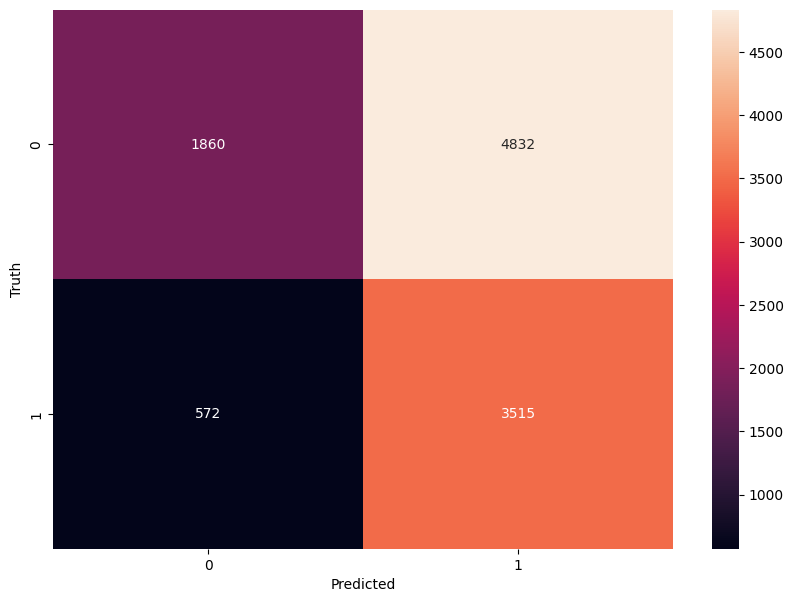

In [15]:
import seaborn as sn

cm = tf.math.confusion_matrix(labels=evaluation_labels2, predictions=y_pred2)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')